In [1]:
from csv import DictReader

with open('octane_database.csv', 'r') as csv_file:
    reader = DictReader(csv_file)
    compounds = [r for r in reader]
csv_file.close()
print(len(compounds))

278


In [2]:
smiles = [c['canonical_smiles'] for c in compounds]
mon = [[float(c['properties.motor_octane_number.value'])] for c in compounds]
ron = [[float(c['properties.research_octane_number.value'])] for c in compounds]
os = [[ron[i][0] - mon[i][0]] for i in range(len(compounds))]

In [3]:
from sklearn.model_selection import train_test_split

mon_smiles_train, mon_smiles_test, mon_train, mon_test = train_test_split(smiles, mon, test_size=0.1, random_state=42)
ron_smiles_train, ron_smiles_test, ron_train, ron_test = train_test_split(smiles, ron, test_size=0.1, random_state=42)
os_smiles_train, os_smiles_test, os_train, os_test = train_test_split(smiles, os, test_size=0.1, random_state=42)

In [4]:
from ecnet.datasets import QSPRDataset

dataset_mon_train = QSPRDataset(mon_smiles_train, mon_train, backend='alvadesc')
dataset_mon_test = QSPRDataset(mon_smiles_test, mon_test, backend='alvadesc')
dataset_ron_train = QSPRDataset(ron_smiles_train, ron_train, backend='alvadesc')
dataset_ron_test = QSPRDataset(ron_smiles_test, ron_test, backend='alvadesc')
dataset_os_train = QSPRDataset(os_smiles_train, os_train, backend='alvadesc')
dataset_os_test = QSPRDataset(os_smiles_test, os_test, backend='alvadesc')

In [5]:
from ecnet.tasks import select_rfr

desc_idx_mon, _ = select_rfr(dataset_mon_train, total_importance=0.9999, n_estimators=25, n_jobs=4)
desc_idx_mon = desc_idx_mon[:250]

desc_idx_ron, _ = select_rfr(dataset_ron_train, total_importance=0.9999, n_estimators=25, n_jobs=4)
desc_idx_ron = desc_idx_ron[:250]

desc_idx_os, _ = select_rfr(dataset_os_train, total_importance=0.9999, n_estimators=25, n_jobs=4)
desc_idx_os = desc_idx_os[:250]

In [6]:
dataset_mon_train.set_desc_index(desc_idx_mon)
dataset_mon_test.set_desc_index(desc_idx_mon)
dataset_ron_train.set_desc_index(desc_idx_ron)
dataset_ron_test.set_desc_index(desc_idx_ron)
dataset_os_train.set_desc_index(desc_idx_os)
dataset_os_test.set_desc_index(desc_idx_os)

In [7]:
from ecnet import ECNet

model_mon = ECNet(dataset_mon_train.desc_vals.shape[1], dataset_mon_train.target_vals.shape[1], 128, 2)
model_ron = ECNet(dataset_ron_train.desc_vals.shape[1], dataset_ron_train.target_vals.shape[1], 128, 2)
model_os = ECNet(dataset_os_train.desc_vals.shape[1], dataset_os_train.target_vals.shape[1], 128, 2)

In [37]:
train_loss_mon, valid_loss_mon = model_mon.fit(
    dataset=dataset_mon_train, valid_size=0.112, verbose=5,
    patience=32, epochs=512, random_state=24, lr=0.001
)
train_loss_mon = train_loss_mon[1:]
valid_loss_mon = valid_loss_mon[1:]

Epoch: 0 | Train loss: 154.8261395875398 | Valid loss: 9223372036854775807
Epoch: 5 | Train loss: 9.412699473870767 | Valid loss: 37.91147232055664
Epoch: 10 | Train loss: 4.83622610246813 | Valid loss: 36.93596649169922
Epoch: 15 | Train loss: 3.935452974594391 | Valid loss: 33.274410247802734
Epoch: 20 | Train loss: 3.4563681735648766 | Valid loss: 32.82816696166992
Epoch: 25 | Train loss: 3.250228649861104 | Valid loss: 34.14470672607422
Epoch: 30 | Train loss: 3.754794692133998 | Valid loss: 37.59504318237305
Epoch: 35 | Train loss: 2.7814189550038932 | Valid loss: 37.29427719116211
Epoch: 40 | Train loss: 3.6002929575808413 | Valid loss: 34.594520568847656


In [38]:
from matplotlib import pyplot as plt
from sklearn.metrics import mean_squared_error, r2_score

mon_target_vals = [t[0] for t in dataset_mon_train.target_vals]
mon_learn_exp, mon_valid_exp = train_test_split(mon_target_vals, test_size=0.112, random_state=24)
mon_train_pred = model_mon(dataset_mon_train.desc_vals).detach().numpy()
mon_train_pred = [t[0] for t in mon_train_pred]
mon_learn_pred, mon_valid_pred = train_test_split(mon_train_pred, test_size=0.112, random_state=24)

mon_test_exp = [t[0] for t in dataset_mon_test.target_vals]
mon_test_pred = model_mon(dataset_mon_test.desc_vals).detach().numpy()
mon_test_pred = [t[0] for t in mon_test_pred]

learn_rmse = mean_squared_error(mon_learn_exp, mon_learn_pred, squared=False)
valid_rmse = mean_squared_error(mon_valid_exp, mon_valid_pred, squared=False)
test_rmse = mean_squared_error(mon_test_exp, mon_test_pred, squared=False)

learn_r2 = r2_score(mon_learn_exp, mon_learn_pred)
valid_r2 = r2_score(mon_valid_exp, mon_valid_pred)
test_r2 = r2_score(mon_test_exp, mon_test_pred)

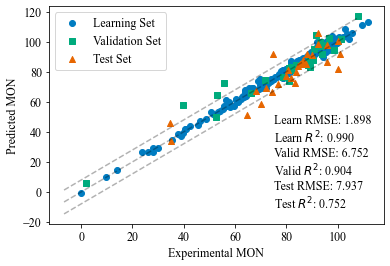

In [39]:
from matplotlib import pyplot as plt
from matplotlib.offsetbox import AnchoredText

min_val = min(min(mon_learn_pred), min(mon_learn_exp)) - 0.05 * max(max(mon_learn_pred), max(mon_learn_exp))
max_val = max(max(mon_learn_pred), max(mon_learn_exp)) - 0.05 * max(max(mon_learn_pred), max(mon_learn_exp))
plt.clf()
plt.rcParams['font.family'] = 'Times New Roman'
plt.rcParams.update({'font.size': 12})
plt.xlabel('Experimental MON')
plt.ylabel('Predicted MON')
plt.plot([min_val, max_val], [min_val, max_val], 'k--', alpha=0.3)
plt.plot([min_val, max_val], [min_val + test_rmse, max_val + test_rmse], 'k--', alpha=0.3)
plt.plot([min_val, max_val], [min_val - test_rmse, max_val - test_rmse], 'k--', alpha=0.3)
plt.scatter(mon_learn_exp, mon_learn_pred, color=(0, 114/235, 178/235), label='Learning Set', marker='o')
plt.scatter(mon_valid_exp, mon_valid_pred, color=(0, 158/235, 115/235), label='Validation Set', marker='s')
plt.scatter(mon_test_exp, mon_test_pred, color=(213/235, 94/235, 0), label='Test Set', marker='^')
plt.legend(loc='upper left')
string = 'Learn RMSE: {:.3f}'.format(learn_rmse) + '\n'
string += 'Learn $R^2$: {:.3f}'.format(learn_r2) + '\n'
string += 'Valid RMSE: {:.3f}'.format(valid_rmse) + '\n'
string += 'Valid $R^2$: {:.3f}'.format(valid_r2) + '\n'
string += 'Test RMSE: {:.3f}'.format(test_rmse) + '\n'
string += 'Test $R^2$: {:.3f}'.format(test_r2)
text_box = AnchoredText(string, frameon=True, loc=4, pad=0.5)
plt.setp(text_box.patch, facecolor='white', edgecolor='w')
plt.gca().add_artist(text_box)
plt.show()

In [40]:
train_loss_ron, valid_loss_ron = model_ron.fit(
    dataset=dataset_ron_train, valid_size=0.112, verbose=5,
    patience=32, epochs=512, random_state=24, lr=0.001
)
train_loss_ron = train_loss_ron[1:]
valid_loss_ron = valid_loss_ron[1:]

Epoch: 0 | Train loss: 136.27929599865064 | Valid loss: 9223372036854775807
Epoch: 5 | Train loss: 8.26995816961065 | Valid loss: 24.675615310668945
Epoch: 10 | Train loss: 5.623443753869684 | Valid loss: 24.766984939575195
Epoch: 15 | Train loss: 5.18131042600752 | Valid loss: 21.872724533081055
Epoch: 20 | Train loss: 4.6206216296634155 | Valid loss: 22.20711326599121
Epoch: 25 | Train loss: 4.57591624302907 | Valid loss: 25.808700561523438
Epoch: 30 | Train loss: 4.8707005848755704 | Valid loss: 21.58730697631836
Epoch: 35 | Train loss: 4.512405283816226 | Valid loss: 21.339214324951172
Epoch: 40 | Train loss: 4.368535445617126 | Valid loss: 23.522306442260742


In [41]:
ron_target_vals = [t[0] for t in dataset_ron_train.target_vals]
ron_learn_exp, ron_valid_exp = train_test_split(ron_target_vals, test_size=0.112, random_state=24)
ron_train_pred = model_ron(dataset_ron_train.desc_vals).detach().numpy()
ron_train_pred = [t[0] for t in ron_train_pred]
ron_learn_pred, ron_valid_pred = train_test_split(ron_train_pred, test_size=0.112, random_state=24)

ron_test_exp = [t[0] for t in dataset_ron_test.target_vals]
ron_test_pred = model_ron(dataset_ron_test.desc_vals).detach().numpy()
ron_test_pred = [t[0] for t in ron_test_pred]

learn_rmse = mean_squared_error(ron_learn_exp, ron_learn_pred, squared=False)
valid_rmse = mean_squared_error(ron_valid_exp, ron_valid_pred, squared=False)
test_rmse = mean_squared_error(ron_test_exp, ron_test_pred, squared=False)

learn_r2 = r2_score(ron_learn_exp, ron_learn_pred)
valid_r2 = r2_score(ron_valid_exp, ron_valid_pred)
test_r2 = r2_score(ron_test_exp, ron_test_pred)

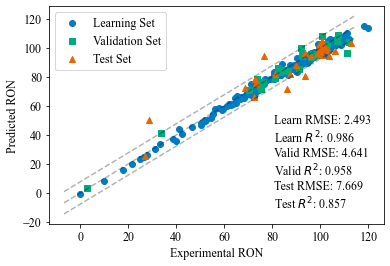

In [42]:
min_val = min(min(ron_learn_pred), min(ron_learn_exp)) - 0.05 * max(max(ron_learn_pred), max(ron_learn_exp))
max_val = max(max(ron_learn_pred), max(ron_learn_exp)) - 0.05 * max(max(ron_learn_pred), max(ron_learn_exp))
plt.clf()
plt.rcParams['font.family'] = 'Times New Roman'
plt.rcParams.update({'font.size': 12})
plt.xlabel('Experimental RON')
plt.ylabel('Predicted RON')
plt.plot([min_val, max_val], [min_val, max_val], 'k--', alpha=0.3)
plt.plot([min_val, max_val], [min_val + test_rmse, max_val + test_rmse], 'k--', alpha=0.3)
plt.plot([min_val, max_val], [min_val - test_rmse, max_val - test_rmse], 'k--', alpha=0.3)
plt.scatter(ron_learn_exp, ron_learn_pred, color=(0, 114/235, 178/235), label='Learning Set', marker='o')
plt.scatter(ron_valid_exp, ron_valid_pred, color=(0, 158/235, 115/235), label='Validation Set', marker='s')
plt.scatter(ron_test_exp, ron_test_pred, color=(213/235, 94/235, 0), label='Test Set', marker='^')
plt.legend(loc='upper left')
string = 'Learn RMSE: {:.3f}'.format(learn_rmse) + '\n'
string += 'Learn $R^2$: {:.3f}'.format(learn_r2) + '\n'
string += 'Valid RMSE: {:.3f}'.format(valid_rmse) + '\n'
string += 'Valid $R^2$: {:.3f}'.format(valid_r2) + '\n'
string += 'Test RMSE: {:.3f}'.format(test_rmse) + '\n'
string += 'Test $R^2$: {:.3f}'.format(test_r2)
text_box = AnchoredText(string, frameon=True, loc=4, pad=0.5)
plt.setp(text_box.patch, facecolor='white', edgecolor='w')
plt.gca().add_artist(text_box)
plt.show()

In [43]:
train_loss_os, valid_loss_os = model_os.fit(
    dataset=dataset_os_train, valid_size=0.112, verbose=5,
    patience=32, epochs=512, random_state=24, lr=0.001
)
train_loss_os = train_loss_os[1:]
valid_loss_os = valid_loss_os[1:]

Epoch: 0 | Train loss: 5.790300601237529 | Valid loss: 9223372036854775807
Epoch: 5 | Train loss: 2.2422145293639586 | Valid loss: 12.483543395996094
Epoch: 10 | Train loss: 1.5996918850116901 | Valid loss: 13.752907752990723
Epoch: 15 | Train loss: 2.4461910316536017 | Valid loss: 15.622106552124023
Epoch: 20 | Train loss: 1.9083571584375054 | Valid loss: 14.770299911499023
Epoch: 25 | Train loss: 1.9149036085283435 | Valid loss: 14.526046752929688
Epoch: 30 | Train loss: 1.5657953657545485 | Valid loss: 14.88361930847168
Epoch: 35 | Train loss: 1.5231910374787476 | Valid loss: 14.08723258972168
Epoch: 40 | Train loss: 1.8356304759377833 | Valid loss: 14.69765567779541
Epoch: 45 | Train loss: 1.4160153758418452 | Valid loss: 14.068710327148438


In [44]:
os_target_vals = [t[0] for t in dataset_os_train.target_vals]
os_learn_exp, os_valid_exp = train_test_split(os_target_vals, test_size=0.112, random_state=24)
os_train_pred = model_os(dataset_os_train.desc_vals).detach().numpy()
os_train_pred = [t[0] for t in os_train_pred]
os_learn_pred, os_valid_pred = train_test_split(os_train_pred, test_size=0.112, random_state=24)

os_test_exp = [t[0] for t in dataset_os_test.target_vals]
os_test_pred = model_os(dataset_os_test.desc_vals).detach().numpy()
os_test_pred = [t[0] for t in os_test_pred]

learn_rmse = mean_squared_error(os_learn_exp, os_learn_pred, squared=False)
valid_rmse = mean_squared_error(os_valid_exp, os_valid_pred, squared=False)
test_rmse = mean_squared_error(os_test_exp, os_test_pred, squared=False)

learn_r2 = r2_score(os_learn_exp, os_learn_pred)
valid_r2 = r2_score(os_valid_exp, os_valid_pred)
test_r2 = r2_score(os_test_exp, os_test_pred)

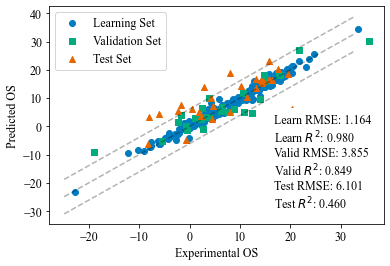

In [45]:
plt.clf()
min_val = min(min(os_learn_pred), min(os_learn_exp)) - 0.05 * max(max(os_learn_pred), max(os_learn_exp))
max_val = max(max(os_learn_pred), max(os_learn_exp)) - 0.05 * max(max(os_learn_pred), max(os_learn_exp))
plt.rcParams['font.family'] = 'Times New Roman'
plt.rcParams.update({'font.size': 12})
plt.xlabel('Experimental OS')
plt.ylabel('Predicted OS')
plt.plot([min_val, max_val], [min_val, max_val], 'k--', alpha=0.3)
plt.plot([min_val, max_val], [min_val + test_rmse, max_val + test_rmse], 'k--', alpha=0.3)
plt.plot([min_val, max_val], [min_val - test_rmse, max_val - test_rmse], 'k--', alpha=0.3)
plt.scatter(os_learn_exp, os_learn_pred, color=(0, 114/235, 178/235), label='Learning Set', marker='o')
plt.scatter(os_valid_exp, os_valid_pred, color=(0, 158/235, 115/235), label='Validation Set', marker='s')
plt.scatter(os_test_exp, os_test_pred, color=(213/235, 94/235, 0), label='Test Set', marker='^')
plt.legend(loc='upper left')
string = 'Learn RMSE: {:.3f}'.format(learn_rmse) + '\n'
string += 'Learn $R^2$: {:.3f}'.format(learn_r2) + '\n'
string += 'Valid RMSE: {:.3f}'.format(valid_rmse) + '\n'
string += 'Valid $R^2$: {:.3f}'.format(valid_r2) + '\n'
string += 'Test RMSE: {:.3f}'.format(test_rmse) + '\n'
string += 'Test $R^2$: {:.3f}'.format(test_r2)
text_box = AnchoredText(string, frameon=True, loc=4, pad=0.5)
plt.setp(text_box.patch, facecolor='white', edgecolor='w')
plt.gca().add_artist(text_box)
plt.show()

In [46]:
dos_learn_exp = [ron_learn_exp[i] - mon_learn_pred[i] for i in range(len(ron_learn_exp))]
dos_valid_exp = [ron_valid_exp[i] - mon_valid_pred[i] for i in range(len(ron_valid_exp))]
dos_test_exp = [ron_test_exp[i] - mon_test_pred[i] for i in range(len(ron_test_exp))]

dos_learn_pred = [ron_learn_pred[i] - mon_learn_pred[i] for i in range(len(ron_learn_pred))]
dos_valid_pred = [ron_valid_pred[i] - mon_valid_pred[i] for i in range(len(ron_valid_pred))]
dos_test_pred = [ron_test_pred[i] - mon_test_pred[i] for i in range(len(ron_test_pred))]

learn_rmse = mean_squared_error(dos_learn_exp, dos_learn_pred, squared=False)
valid_rmse = mean_squared_error(dos_valid_exp, dos_valid_pred, squared=False)
test_rmse = mean_squared_error(dos_test_exp, dos_test_pred, squared=False)

learn_r2 = r2_score(dos_learn_exp, dos_learn_pred)
valid_r2 = r2_score(dos_valid_exp, dos_valid_pred)
test_r2 = r2_score(dos_test_exp, dos_test_pred)

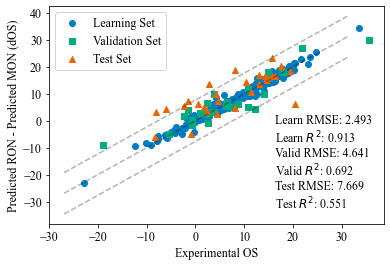

In [47]:
plt.clf()
min_val = min(min(dos_learn_pred), min(dos_learn_exp)) - 0.05 * max(max(dos_learn_pred), max(dos_learn_exp))
max_val = max(max(dos_learn_pred), max(dos_learn_exp)) - 0.05 * max(max(dos_learn_pred), max(dos_learn_exp))
plt.rcParams['font.family'] = 'Times New Roman'
plt.rcParams.update({'font.size': 12})
plt.xlabel('Experimental OS')
plt.ylabel('Predicted RON - Predicted MON (dOS)')
plt.plot([min_val, max_val], [min_val, max_val], 'k--', alpha=0.3)
plt.plot([min_val, max_val], [min_val + test_rmse, max_val + test_rmse], 'k--', alpha=0.3)
plt.plot([min_val, max_val], [min_val - test_rmse, max_val - test_rmse], 'k--', alpha=0.3)
plt.scatter(os_learn_exp, os_learn_pred, color=(0, 114/235, 178/235), label='Learning Set', marker='o')
plt.scatter(os_valid_exp, os_valid_pred, color=(0, 158/235, 115/235), label='Validation Set', marker='s')
plt.scatter(os_test_exp, os_test_pred, color=(213/235, 94/235, 0), label='Test Set', marker='^')
plt.legend(loc='upper left')
string = 'Learn RMSE: {:.3f}'.format(learn_rmse) + '\n'
string += 'Learn $R^2$: {:.3f}'.format(learn_r2) + '\n'
string += 'Valid RMSE: {:.3f}'.format(valid_rmse) + '\n'
string += 'Valid $R^2$: {:.3f}'.format(valid_r2) + '\n'
string += 'Test RMSE: {:.3f}'.format(test_rmse) + '\n'
string += 'Test $R^2$: {:.3f}'.format(test_r2)
text_box = AnchoredText(string, frameon=True, loc=4, pad=0.5)
plt.setp(text_box.patch, facecolor='white', edgecolor='w')
plt.gca().add_artist(text_box)
plt.show()

In [48]:
model_mon.save('model_mon.pt')
model_ron.save('model_ron.pt')
model_os.save('model_os.pt')